<a href="https://colab.research.google.com/github/A-Istrate/80629_Project/blob/main/ML_TPG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import math
import copy
from random import seed
from random import random
import random
import matplotlib.pyplot as plt  # import matplotlib for plotting and visualization
import matplotlib
import PIL
import PIL.Image
import tensorflow as tf
import pathlib
import os
import re
import sklearn
from tensorflow.keras import layers
from sklearn.utils import class_weight


Checking our images

In [6]:
## images path
path_s = r"C:\Users\istra\Google Drive\Cours HEC\Maitrise\Semestre 2\Machine_Learning\TP GROUPE\book_covers2"
path = pathlib.Path(path_s)
image_count=len(list(path.glob('*/*.jpg')))
print(image_count)

43390


Checking a childrens book

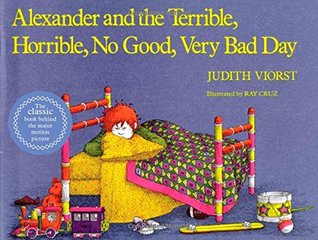

In [3]:
children = list(path.glob('Childrens/*'))
PIL.Image.open(str(children[12]))

Creating a dataset

In [7]:
batch_size =32
img_height = 150
img_width =100
list_ds = tf.data.Dataset.list_files(str(path_s+"\*/*.jp*"),shuffle=False)
list_ds = list_ds.shuffle(image_count,reshuffle_each_iteration=False)

In [7]:
for f in list_ds.take(5):
  print(f.numpy())

b'C:\\Users\\istra\\Google Drive\\Cours HEC\\Maitrise\\Semestre 2\\Machine_Learning\\TP GROUPE\\book_covers2\\Fantasy\\632.jpg'
b'C:\\Users\\istra\\Google Drive\\Cours HEC\\Maitrise\\Semestre 2\\Machine_Learning\\TP GROUPE\\book_covers2\\Biography\\53712.jpg'
b'C:\\Users\\istra\\Google Drive\\Cours HEC\\Maitrise\\Semestre 2\\Machine_Learning\\TP GROUPE\\book_covers2\\Young Adult\\52151.jpg'
b'C:\\Users\\istra\\Google Drive\\Cours HEC\\Maitrise\\Semestre 2\\Machine_Learning\\TP GROUPE\\book_covers2\\Historical\\39613.jpg'
b'C:\\Users\\istra\\Google Drive\\Cours HEC\\Maitrise\\Semestre 2\\Machine_Learning\\TP GROUPE\\book_covers2\\Romance\\23106.jpg'


In [8]:
class_names = np.array(sorted([item.name for item in path.glob('*') if os.path.isdir(item)]))
print(class_names)

['Biography' 'Childrens' 'Fantasy' 'Historical' 'Horror' 'Mystery & Crime'
 'Poetry' 'Politics & History' 'Religion & Philosophy' 'Romance'
 'Science Fiction' 'Sequential Art' 'Young Adult']


In [7]:
#val_size = int(image_count*0.2)
#train_ds = list_ds.skip(val_size)
#val_ds = list_ds.take(val_size)

In [9]:
cd =dict(enumerate(class_names))

In [285]:
cd

{0: 'Biography',
 1: 'Childrens',
 2: 'Fantasy',
 3: 'Historical',
 4: 'Horror',
 5: 'Mystery & Crime',
 6: 'Poetry',
 7: 'Politics & History',
 8: 'Religion & Philosophy',
 9: 'Romance',
 10: 'Science Fiction',
 11: 'Sequential Art',
 12: 'Young Adult'}

In [10]:
classdict={}
tf_filter=[]
sample_classes=[]
for item in list_ds:
   itemname = str(item.numpy())
   itemname = itemname.replace(path_s.replace('\\',"\\\\"),"")
   img_class=itemname.split(sep="\\")[2]
   sample_classes.append(img_class)
   classdict[img_class]=classdict.get(img_class,0)+1
   if classdict[img_class] >1000 :
       tf_filter.append(False)
   else:
        tf_filter.append(True)

#small_list = list_ds.filter(lambda x:  tf.reduce_all(tf_filter))
   

In [11]:
classdict


{'Fantasy': 8653,
 'Romance': 6461,
 'Mystery & Crime': 3947,
 'Biography': 1970,
 'Horror': 1302,
 'Young Adult': 4499,
 'Politics & History': 2205,
 'Religion & Philosophy': 3022,
 'Historical': 4451,
 'Science Fiction': 2563,
 'Sequential Art': 1589,
 'Childrens': 1636,
 'Poetry': 1092}

In [12]:
small_list_c = [[item,c]for (item,v,c) in zip(list_ds,tf_filter,sample_classes) if v]

We shuffle the list again

In [13]:
random.shuffle(small_list_c)

We create train and validation samples with exactly the same number of observations for each class

In [15]:
classdict_small={}
small_train_ds_l=[]
small_val_ds_l=[]
for item,c in small_list_c:
    classdict_small[c]=classdict_small.get(c,0)+1
    if classdict_small[c] >800:
        small_val_ds_l.append(item)
    else:
        small_train_ds_l.append(item)


In [16]:
small_train_ds  = tf.data.Dataset.from_tensor_slices(small_train_ds_l)
small_val_ds = tf.data.Dataset.from_tensor_slices(small_val_ds_l)

In [17]:
print(tf.data.experimental.cardinality(small_train_ds).numpy())
print(tf.data.experimental.cardinality(small_val_ds).numpy())

10400
2600


In [18]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  
  return tf.argmax(one_hot)

In [19]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [20]:
def process_path(file_path):
    label = get_label(file_path)
  # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
         
    return img,label


In [21]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
AUTOTUNE = tf.data.AUTOTUNE
small_train_ds = small_train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
small_val_ds = small_val_ds.map(process_path, num_parallel_calls=AUTOTUNE)


Image shape:  (150, 100, 3)
Label:  12


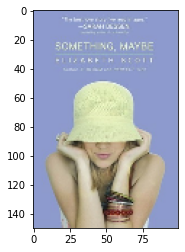

In [22]:
for image, label in small_train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())
  plt.imshow(image.numpy().astype("uint8"))

In [23]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000, reshuffle_each_iteration=False)
  #print(ds)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

def configure_for_performance_val(ds):
  ds = ds.cache()
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

small_train_ds = configure_for_performance(small_train_ds)
small_val_ds = configure_for_performance(small_val_ds)

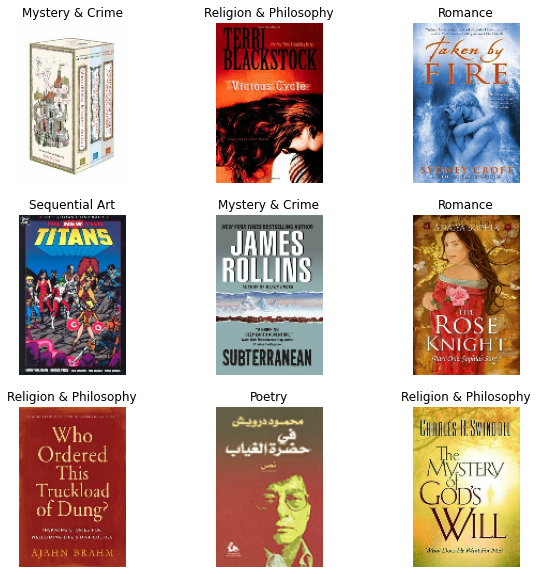

In [24]:
image_batch, label_batch = next(iter(small_train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

Classes

In [160]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
num_classes=13

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3,strides=1, activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Conv2D(32, 3,strides=1,  activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Conv2D(64, 3,strides=1,  activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])
model.compile(
   # optimizer=tf.keras.optimizers.RMSprop(
   # learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=0.001, 
  #  name='RMSprop'
#),
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.0001,
        epsilon=0.1
    ),
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [161]:
history=model.fit(
  small_train_ds,
  validation_data=small_val_ds,
  epochs=50
)

Epoch 1/50
325/325 [==============================] - 43s 132ms/step - loss: 2.5671 - accuracy: 0.0801 - val_loss: 2.5638 - val_accuracy: 0.0727
Epoch 2/50
325/325 [==============================] - 43s 132ms/step - loss: 2.5632 - accuracy: 0.0789 - val_loss: 2.5604 - val_accuracy: 0.0762
Epoch 3/50
325/325 [==============================] - 44s 134ms/step - loss: 2.5597 - accuracy: 0.0876 - val_loss: 2.5578 - val_accuracy: 0.0904
Epoch 4/50
325/325 [==============================] - 43s 133ms/step - loss: 2.5563 - accuracy: 0.0859 - val_loss: 2.5550 - val_accuracy: 0.0927
Epoch 5/50
325/325 [==============================] - 42s 130ms/step - loss: 2.5531 - accuracy: 0.0945 - val_loss: 2.5519 - val_accuracy: 0.0981
Epoch 6/50
325/325 [==============================] - 44s 134ms/step - loss: 2.5497 - accuracy: 0.1006 - val_loss: 2.5486 - val_accuracy: 0.1019
Epoch 7/50
325/325 [==============================] - 42s 129ms/step - loss: 2.5453 - accuracy: 0.1071 - val_loss: 2.5446 - val_ac

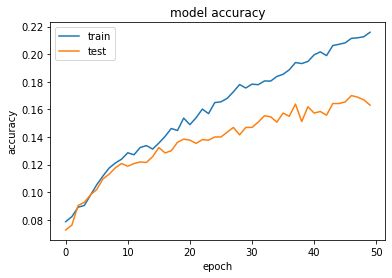

In [162]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [286]:
model.save("model_small_samples_50.h5")

In [277]:
predictions = model.predict(small_val_ds)
predicted_classes = np.argmax(predictions, axis=1)

In [ ]:
a =[ tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(item.numpy(),target_size=(150,100)))for item in small_val_ds_l]


In [278]:
vclasses = list()
vclasses = [[c.numpy() for c in object[1]]for object in small_val_ds]

In [279]:
validation_classes = np.concatenate(vclasses).ravel()

In [282]:
unique,counts = np.unique(validation_classes, return_counts=True)
print(counts)

[200 200 200 200 200 200 200 200 200 200 200 200 200]


In [280]:
from sklearn.metrics import classification_report
print(classification_report(validation_classes, predicted_classes, target_names=class_names))

                       precision    recall  f1-score   support

            Biography       0.19      0.24      0.21       200
            Childrens       0.27      0.17      0.20       200
              Fantasy       0.07      0.01      0.01       200
           Historical       0.15      0.23      0.18       200
               Horror       0.23      0.32      0.27       200
      Mystery & Crime       0.28      0.09      0.13       200
               Poetry       0.39      0.14      0.20       200
   Politics & History       0.17      0.15      0.16       200
Religion & Philosophy       0.15      0.21      0.17       200
              Romance       0.18      0.34      0.23       200
      Science Fiction       0.35      0.12      0.18       200
       Sequential Art       0.22      0.58      0.32       200
          Young Adult       0.27      0.04      0.07       200

             accuracy                           0.20      2600
            macro avg       0.22      0.20      0.18 

In [283]:
def prediction_score(valid,predictions,cnames=class_names):
    pred = np.argmax(predictions, axis=1)
    pred2 = np.argsort(predictions,axis=1)[:,-2]
    pred3 = np.argsort(predictions,axis=1)[:,-3]
    dict_c = dict(enumerate(cnames))
    scores=[]
    for v,p1,p2,p3 in zip(valid,pred,pred2,pred3):
        score=0
        if v == p1: score=1
        elif v == p2: score =0.75
        elif v == p3: score =0.5
        scores.append([dict_c.get(v),score])
    scores_df = pd.DataFrame(scores,columns=["genre","score"])
    meanscore =np.round(scores_df["score"].mean(),3)
    print("The average score is %s" %meanscore)
    return scores_df.groupby("genre").mean("score")

In [284]:
prediction_score(validation_classes,predictions)

The average score is 0.361


,score
genre,
Biography,0.44500
Childrens,0.36125
Fantasy,0.09250
Historical,0.46125
Horror,0.45875
Mystery & Crime,0.22875
Poetry,0.30750
Politics & History,0.34375
Religion & Philosophy,0.37500


Online augmentation of the  data

In [288]:
num_classes=13

model2 = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomFlip(),
  layers.experimental.preprocessing.RandomZoom(height_factor=0.2),
  layers.experimental.preprocessing.RandomRotation(factor=0.3),
  layers.Conv2D(16, 3,strides=1, activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Conv2D(32, 3,strides=1,  activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Conv2D(64, 3,strides=1,  activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])
model2.compile(
 
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.0001,
        epsilon=0.1
    ),
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [292]:
model2.compile(
 
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.001,
        epsilon=0.1
    ),
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [293]:
history2=model2.fit(
  small_train_ds,
  validation_data=small_val_ds,
  epochs=50
)

Epoch 1/50
325/325 [==============================] - 51s 153ms/step - loss: 2.4307 - accuracy: 0.1677 - val_loss: 2.5103 - val_accuracy: 0.1404
Epoch 2/50
325/325 [==============================] - 51s 158ms/step - loss: 2.4414 - accuracy: 0.1616 - val_loss: 2.5286 - val_accuracy: 0.1354
Epoch 3/50
325/325 [==============================] - 52s 159ms/step - loss: 2.4428 - accuracy: 0.1566 - val_loss: 2.5058 - val_accuracy: 0.1431
Epoch 4/50
325/325 [==============================] - 52s 160ms/step - loss: 2.4361 - accuracy: 0.1630 - val_loss: 2.5122 - val_accuracy: 0.1415
Epoch 5/50
325/325 [==============================] - 52s 160ms/step - loss: 2.4372 - accuracy: 0.1644 - val_loss: 2.5147 - val_accuracy: 0.1442
Epoch 6/50
325/325 [==============================] - 54s 167ms/step - loss: 2.4296 - accuracy: 0.1696 - val_loss: 2.5035 - val_accuracy: 0.1450
Epoch 7/50
325/325 [==============================] - 54s 165ms/step - loss: 2.4320 - accuracy: 0.1648 - val_loss: 2.5036 - val_ac

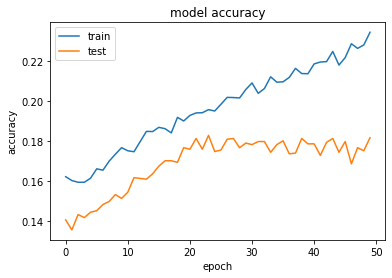

In [294]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [295]:
predictions2 = model2.predict(small_val_ds)
predicted_classes2 = np.argmax(predictions2, axis=1)

In [296]:
#from sklearn.metrics import classification_report
print(classification_report(validation_classes, predicted_classes2, target_names=class_names))

                       precision    recall  f1-score   support

            Biography       0.13      0.01      0.02       200
            Childrens       0.28      0.52      0.37       200
              Fantasy       0.14      0.03      0.04       200
           Historical       0.22      0.10      0.14       200
               Horror       0.21      0.19      0.20       200
      Mystery & Crime       0.15      0.37      0.21       200
               Poetry       0.24      0.18      0.20       200
   Politics & History       0.14      0.26      0.18       200
Religion & Philosophy       0.15      0.18      0.16       200
              Romance       0.17      0.06      0.08       200
      Science Fiction       0.13      0.21      0.16       200
       Sequential Art       0.24      0.23      0.23       200
          Young Adult       0.19      0.03      0.05       200

             accuracy                           0.18      2600
            macro avg       0.18      0.18      0.16 

In [297]:
num_classes=13

model3 = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomFlip(),
  layers.experimental.preprocessing.RandomZoom(height_factor=0.2),
  layers.experimental.preprocessing.RandomRotation(factor=0.3),
  layers.Conv2D(16, 3,strides=1, activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Conv2D(32, 3,strides=1,  activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Conv2D(64, 3,strides=1,  activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])
model3.compile(
 
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.01,
        epsilon=0.01
    ),
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [298]:
history3=model3.fit(
  small_train_ds,
  validation_data=small_val_ds,
  epochs=50
)

Epoch 1/50
325/325 [==============================] - 49s 149ms/step - loss: 2.5587 - accuracy: 0.0912 - val_loss: 2.5482 - val_accuracy: 0.0992
Epoch 2/50
325/325 [==============================] - 47s 145ms/step - loss: 2.5317 - accuracy: 0.1138 - val_loss: 2.5260 - val_accuracy: 0.1219
Epoch 3/50
325/325 [==============================] - 46s 140ms/step - loss: 2.5216 - accuracy: 0.1204 - val_loss: 2.5244 - val_accuracy: 0.1223
Epoch 4/50
325/325 [==============================] - 49s 150ms/step - loss: 2.5195 - accuracy: 0.1190 - val_loss: 2.5192 - val_accuracy: 0.1265
Epoch 5/50
325/325 [==============================] - 49s 151ms/step - loss: 2.5162 - accuracy: 0.1161 - val_loss: 2.5221 - val_accuracy: 0.1165
Epoch 6/50
325/325 [==============================] - 50s 154ms/step - loss: 2.5127 - accuracy: 0.1210 - val_loss: 2.5186 - val_accuracy: 0.1200
Epoch 7/50
325/325 [==============================] - 51s 156ms/step - loss: 2.5152 - accuracy: 0.1201 - val_loss: 2.5205 - val_ac

In [27]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
num_classes=13

model4 = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3,strides=1, activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Conv2D(32, 3,strides=1,  activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Conv2D(64, 3,strides=1,  activation='relu'),
  layers.Dropout(0.5),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])
model4.compile(
  
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.001,
        epsilon=0.1
    ),
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [28]:
history4=model4.fit(
  small_train_ds,
  validation_data=small_val_ds,
  epochs=50
)

Epoch 1/50
325/325 [==============================] - 73s 220ms/step - loss: 2.5768 - accuracy: 0.0821 - val_loss: 2.5615 - val_accuracy: 0.0896
Epoch 2/50
325/325 [==============================] - 70s 215ms/step - loss: 2.5601 - accuracy: 0.0841 - val_loss: 2.5518 - val_accuracy: 0.1177
Epoch 3/50
325/325 [==============================] - 72s 221ms/step - loss: 2.5471 - accuracy: 0.1043 - val_loss: 2.5307 - val_accuracy: 0.1238
Epoch 4/50
325/325 [==============================] - 73s 225ms/step - loss: 2.5207 - accuracy: 0.1228 - val_loss: 2.5199 - val_accuracy: 0.1246
Epoch 5/50
325/325 [==============================] - 71s 219ms/step - loss: 2.5125 - accuracy: 0.1196 - val_loss: 2.5106 - val_accuracy: 0.1212
Epoch 6/50
325/325 [==============================] - 69s 211ms/step - loss: 2.4949 - accuracy: 0.1373 - val_loss: 2.4932 - val_accuracy: 0.1458
Epoch 7/50
325/325 [==============================] - 70s 216ms/step - loss: 2.4837 - accuracy: 0.1397 - val_loss: 2.4805 - val_ac